In [3]:
# Preprocessing
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
fake_df = pd.read_csv("../data/Fake.csv")
true_df = pd.read_csv("../data/True.csv")

# create new column that combines title and text together called title_text_combined
true_df['title_text_combined'] = true_df['title'] + " " + true_df['text']
# add response column and set to 1 for true dataset
true_df["response"] = 1

# create new column that combines title and text together called title_text_combined
fake_df['title_text_combined'] = fake_df['title'] + " " + fake_df['text']
# add response column and set to 1 for true dataset
fake_df["response"] = 0

# remove title, text, subject and date columns
fake_df.drop(["title", "text", "subject","date"],axis = 1,inplace = True)
true_df.drop(["title", "text", "subject","date"],axis = 1,inplace = True)

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    return ' '.join(words)

# merging fake and true dataframes together
merged_df = pd.concat([true_df, fake_df], ignore_index=True)
merged_df['title_text_combined'] = merged_df['title_text_combined'].apply(preprocess_text)

X = merged_df['title_text_combined'].values
Y = merged_df['response'].values

# start splitting data into test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=42)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

# Tokenize the text data
max_words = 10000  #  Maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [5]:
# RNN-Bidirectional LSTM

import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

embedding_dim = 50

# length of the longest sentence in dataset
max_length = 500

# To fit the data into any neural network, we need to convert the data into sequence matrices
x_train_padded = sequence.pad_sequences(x_train_tokens,maxlen=max_length,padding='post')
x_test_padded = sequence.pad_sequences(x_test_tokens,maxlen=max_length,padding='post')

# Define model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(x_train_padded, y_train, epochs=10, validation_split=0.2)

# Evaluate model
test_loss, test_acc = model.evaluate(x_test_padded, y_test)
print('Test Accuracy:', test_acc)

Epoch 1/10
898/898 [==============================] - 205s 225ms/step - loss: 0.0726 - accuracy: 0.9788 - val_loss: 0.0118 - val_accuracy: 0.9967
Epoch 2/10
898/898 [==============================] - 197s 220ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0080 - val_accuracy: 0.9976
Epoch 3/10
898/898 [==============================] - 200s 222ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0101 - val_accuracy: 0.9965
Epoch 4/10
898/898 [==============================] - 201s 224ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0774 - val_accuracy: 0.9876
Epoch 5/10
898/898 [==============================] - 194s 216ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0168 - val_accuracy: 0.9961
Epoch 6/10
898/898 [==============================] - 194s 216ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0232 - val_accuracy: 0.9942
Epoch 7/10
898/898 [==============================] - 196s 218ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0305 -

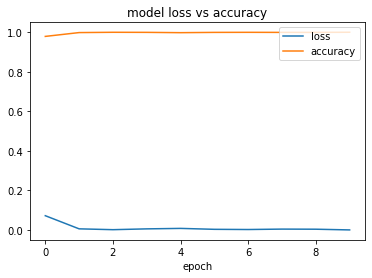

In [6]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()